# Stochastic partial differiential equations - Precision matrices

- Load the required modules

In [33]:
import logging
from pathlib import Path
import os
from typing import Optional, Union, Tuple, Callable
import numpy as np
import numpy.typing as npt
import scipy
import sksparse
from scipy.sparse import lil_matrix, csc_matrix
from sksparse.cholmod import cholesky, Factor
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from nested_grid_plotter import NestedGridPlotter, multi_imshow
import spde
import gstools as gs

- Type hints definition for numpy arrays

In [34]:
NDArrayFloat = npt.NDArray[np.float64]
NDArrayInt = npt.NDArray[np.int64]
Int = Union[int, NDArrayInt]

- Set-up logging level

In [35]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [36]:
logging.info(f"numpy version = {np.__version__}")
logging.info(f"scipy version = {scipy.__version__}")
logging.info(f"sksparse version = {sksparse.__version__}")
logging.info(f"matplotlib version = {mpl.__version__}")

INFO:root:numpy version = 1.23.5
INFO:root:scipy version = 1.9.1
INFO:root:sksparse version = 0.4.8
INFO:root:matplotlib version = 3.7.1


- Set a random number generator to obtain reproducible results. Here , we generate a seed from a cool sentence (Note: this is an incremental generator)


In [37]:
rng = np.random.default_rng(np.abs(hash("mike is the best")))

- Create a directory to store the exported figures

In [38]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

The precision matrix $\bm{Q}$ of $\bm{Z}$ (i.e. the inverse of its covariance matrix) reads :

$\bm{Q} = (dx \times dy)\bm{A}^{T}\bm{A}$

$\bm{Q}$ is thus a sparse matrix, whose expression is entirely determined by the discretization of the differential operator.

Note: now we consider alpha and the variance correction factor.

## 2d case

In [39]:
spatial_dim: int = 2
nx: int = 100
ny: int = 150
dx = dy = 5.0  # mesh size
kappa: float = 1 / 30  # inverse of length scale
alpha: float = 1  # regularity parameter

In [40]:
alpha1 = 1
nu1 = 2 * alpha1 - spatial_dim / 2
Q_a1 = spde.get_precision_matrix_2d(nx, ny, dx, dy, kappa, alpha1)
alpha2 = 2
nu2 = 2 * alpha2 - spatial_dim / 2
Q_a2 = spde.get_precision_matrix_2d(nx, ny, dx, dy, kappa, alpha2)
alpha3 = 3
nu3 = 2 * alpha3 - spatial_dim / 2
Q_a3 = spde.get_precision_matrix_2d(nx, ny, dx, dy, kappa, alpha3)

- Check the sparcity: it decreases when $\alpha$ increases

In [41]:
logging.info(f"Q_a1 sparcity = {Q_a1.count_nonzero() / np.product(Q_a1.shape):.6f}")
logging.info(f"Q_a2 sparcity = {Q_a2.count_nonzero() / np.product(Q_a2.shape):.6f}")
logging.info(f"Q_a3 sparcity = {Q_a3.count_nonzero() / np.product(Q_a3.shape):.6f}")

INFO:root:Q_a1 sparcity = 0.000856
INFO:root:Q_a2 sparcity = 0.000856
INFO:root:Q_a3 sparcity = 0.000856


# Non conditional simulation from precision matrix

In [42]:
from scipy.sparse.linalg import gmres

In [43]:
# white noise with size nx * ny -> scale is the standard deviation
w = rng.normal(loc=0, scale=np.sqrt(1 / np.prod([dx, dy])), size=Q_a1.shape[0])

# Use a LU preconditioner to get faster computation
z, info = gmres(Q_a1, w, M=spde.get_preconditioner(Q_a1), atol=1e-15)

(array([  27.,   78.,  142.,  139.,  130.,  152.,  229.,  245.,  297.,
         357.,  440.,  415.,  448.,  681.,  776.,  940., 1040., 1004.,
         972.,  870.,  710.,  662.,  663.,  609.,  475.,  379.,  282.,
         272.,  263.,  268.,  237.,  178.,  137.,   72.,   57.,   48.,
          29.,   25.,   26.,   26.,   20.,   25.,   21.,   26.,   18.,
          23.,   18.,   17.,   18.,   14.]),
 array([-3.63593802, -3.40436464, -3.17279126, -2.94121788, -2.7096445 ,
        -2.47807112, -2.24649774, -2.01492436, -1.78335098, -1.5517776 ,
        -1.32020422, -1.08863084, -0.85705746, -0.62548408, -0.3939107 ,
        -0.16233732,  0.06923606,  0.30080944,  0.53238282,  0.7639562 ,
         0.99552958,  1.22710296,  1.45867634,  1.69024972,  1.9218231 ,
         2.15339648,  2.38496986,  2.61654324,  2.84811662,  3.07969001,
         3.31126339,  3.54283677,  3.77441015,  4.00598353,  4.23755691,
         4.46913029,  4.70070367,  4.93227705,  5.16385043,  5.39542381,
         5.62699

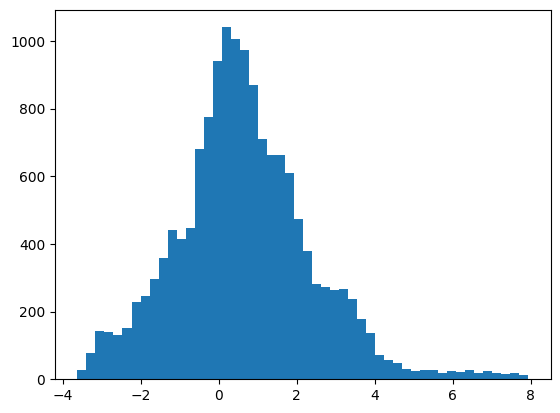

In [44]:
plt.hist(z.flatten(), bins=50)

In [45]:
cholQ_a1 = cholesky(Q_a1.tocsc())
z_nc_a1 = spde.simu_nc(cholQ_a1, rng)

cholQ_a2 = cholesky(Q_a2.tocsc())
z_nc_a2 = spde.simu_nc(cholQ_a2, rng)

cholQ_a3 = cholesky(Q_a3.tocsc())
z_nc_a3 = spde.simu_nc(cholQ_a3, rng)

In [46]:
np.std(z_nc_a3)

2.2542319368961576e-06

(array([   4.,    6.,   10.,    8.,   14.,    9.,    8.,   13.,   17.,
          32.,   42.,   54.,   63.,   85.,   93.,  118.,  120.,  161.,
         205.,  264.,  341.,  401.,  478.,  590.,  685.,  751.,  902.,
        1032.,  980., 1059.,  961.,  988.,  884.,  759.,  633.,  510.,
         399.,  345.,  265.,  199.,  139.,  110.,   67.,   65.,   48.,
          26.,   24.,   19.,   11.,    3.]),
 array([-7.47608717e-03, -7.20696447e-03, -6.93784178e-03, -6.66871908e-03,
        -6.39959638e-03, -6.13047369e-03, -5.86135099e-03, -5.59222830e-03,
        -5.32310560e-03, -5.05398291e-03, -4.78486021e-03, -4.51573752e-03,
        -4.24661482e-03, -3.97749213e-03, -3.70836943e-03, -3.43924674e-03,
        -3.17012404e-03, -2.90100135e-03, -2.63187865e-03, -2.36275596e-03,
        -2.09363326e-03, -1.82451057e-03, -1.55538787e-03, -1.28626518e-03,
        -1.01714248e-03, -7.48019786e-04, -4.78897091e-04, -2.09774396e-04,
         5.93482992e-05,  3.28470994e-04,  5.97593690e-04,  8.667163

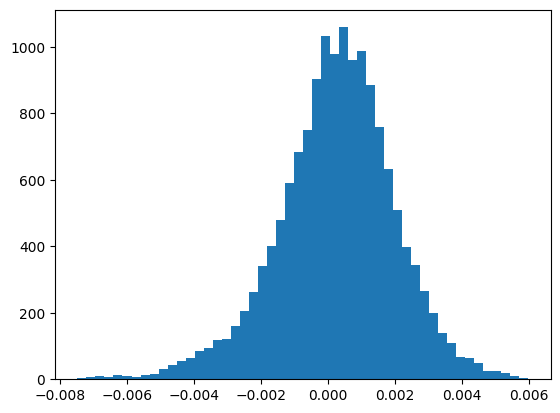

In [47]:
plt.hist(z_nc_a2.flatten(), bins=50)

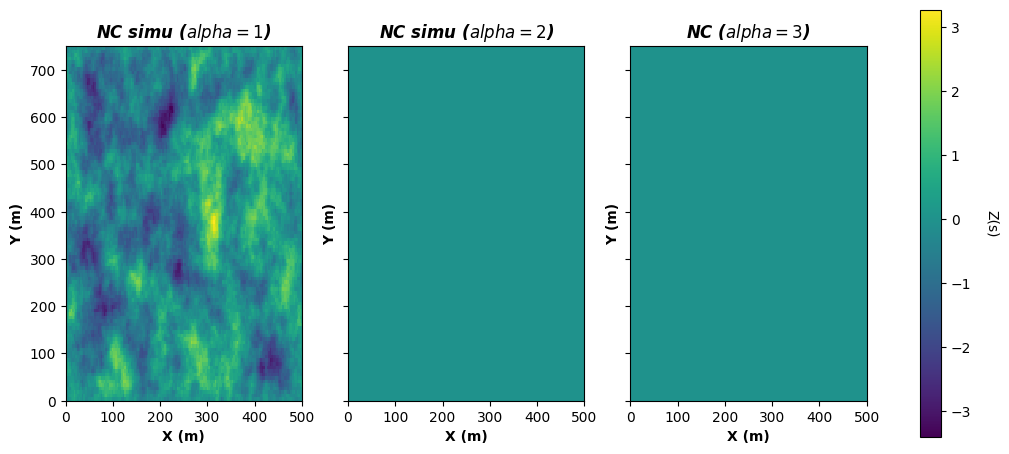

In [48]:
from nested_grid_plotter import NestedGridPlotter

plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 4.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "NC simu ($alpha=1$)": z_nc_a1.reshape(ny, nx),
        "NC simu ($alpha=2$)": z_nc_a2.reshape(ny, nx),
        "NC ($alpha=3$)": z_nc_a3.reshape(ny, nx),
    },
    cbar_title="Z(s)",
    imshow_kwargs={
        "cmap": plt.get_cmap("viridis"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
    },
    xlabel="X (m)",
    ylabel="Y (m)",
)

fname = "nc_simu_effect_of_regularity_parameter"
for format in ["png", "pdf"]:
    plotter.fig.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

(array([   4.,    6.,   10.,    8.,   14.,    9.,    8.,   13.,   17.,
          32.,   42.,   54.,   63.,   85.,   93.,  118.,  120.,  161.,
         205.,  264.,  341.,  401.,  478.,  590.,  685.,  751.,  902.,
        1032.,  980., 1059.,  961.,  988.,  884.,  759.,  633.,  510.,
         399.,  345.,  265.,  199.,  139.,  110.,   67.,   65.,   48.,
          26.,   24.,   19.,   11.,    3.]),
 array([-7.47608717e-03, -7.20696447e-03, -6.93784178e-03, -6.66871908e-03,
        -6.39959638e-03, -6.13047369e-03, -5.86135099e-03, -5.59222830e-03,
        -5.32310560e-03, -5.05398291e-03, -4.78486021e-03, -4.51573752e-03,
        -4.24661482e-03, -3.97749213e-03, -3.70836943e-03, -3.43924674e-03,
        -3.17012404e-03, -2.90100135e-03, -2.63187865e-03, -2.36275596e-03,
        -2.09363326e-03, -1.82451057e-03, -1.55538787e-03, -1.28626518e-03,
        -1.01714248e-03, -7.48019786e-04, -4.78897091e-04, -2.09774396e-04,
         5.93482992e-05,  3.28470994e-04,  5.97593690e-04,  8.667163

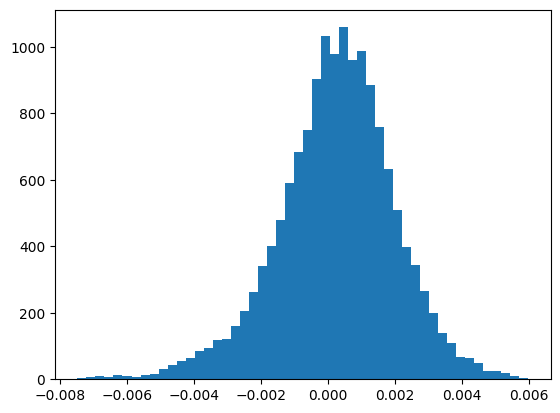

In [49]:
plt.hist(z_nc_a2.flatten(), bins=50)

- As for the previous approach, calculation of the average over several simulations of the experimental variogram

In [50]:
nb_sim = 10  # nomber of simulations
varexp_alpha1 = 0
varexp_alpha2 = 0
varexp_alpha3 = 0

field_dimension = 2  # field dimension

# Variographic parameters: number of points selected in a simulation for the calculation
# of the experimental variogram
n0 = int(0.2 * (nx * ny))
# Spacestep between points
lag = 4
nbpts = 20  # number of points in the variogram

for i in range(nb_sim):
    z0_1 = spde.simu_nc(cholQ_a1, rng)
    z0_2 = spde.simu_nc(cholQ_a2, rng)
    z0_3 = spde.simu_nc(cholQ_a3, rng)

    varexp_alpha1 = (
        varexp_alpha1
        + spde.get_exp_var(z0_1, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim
    )
    varexp_alpha2 = (
        varexp_alpha2
        + spde.get_exp_var(z0_2, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim
    )
    varexp_alpha3 = (
        varexp_alpha3
        + spde.get_exp_var(z0_3, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim
    )

# Add the point (0.0) to varexp -> no nugget effect here
varexp_alpha1 = np.insert(varexp_alpha1, 0, values=0, axis=0)
varexp_alpha2 = np.insert(varexp_alpha2, 0, values=0, axis=0)
varexp_alpha3 = np.insert(varexp_alpha3, 0, values=0, axis=0)

/home/acollet/workspace/spde_practical/spde.py:1289: RuntimeWarning: Mean of empty slice.
  varexp = np.array([diff_z[lagcut == i].mean() / 2 for i in range(1, nbpts + 1)])
/home/acollet/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


- We use gstools to estimate variograms

In [51]:
mat_val_a1 = 1 - spde.matern_kernel(varexp_alpha1[:, 0], l=1 / kappa, v=nu1)
mat_val_a2 = 1 - spde.matern_kernel(varexp_alpha2[:, 0], l=1 / kappa, v=nu2)
mat_val_a3 = 1 - spde.matern_kernel(varexp_alpha3[:, 0], l=1 / kappa, v=nu3)

In [52]:
varexp_alpha2[:, 0]

array([ 0.,  2.,  6., 10., 14., 18., 22., 26., 30., 34., 38., 42., 46.,
       50., 54., 58., 62., 66., 70., 74., 78.])

- Plot the experiemental variogram vs. the theoretical one

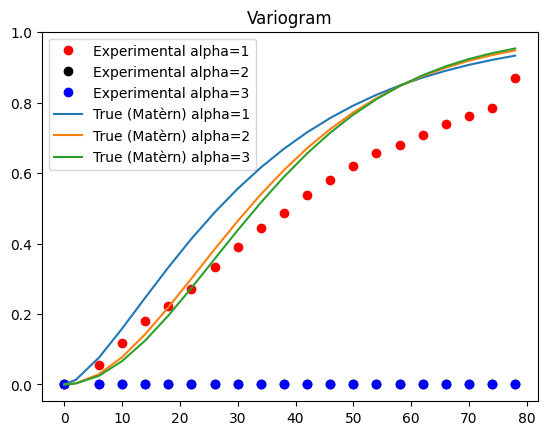

In [53]:
plt.plot(
    varexp_alpha1[:, 0],
    varexp_alpha1[:, 1],
    marker="o",
    label="Experimental alpha=1",
    c="r",
    linestyle="None",
)
plt.plot(
    varexp_alpha2[:, 0],
    varexp_alpha2[:, 1],
    marker="o",
    label="Experimental alpha=2",
    c="k",
    linestyle="None",
)
plt.plot(
    varexp_alpha3[:, 0],
    varexp_alpha3[:, 1],
    marker="o",
    label="Experimental alpha=3",
    c="b",
    linestyle="None",
)


mat_val_a1 = 1 - spde.matern_kernel(varexp_alpha1[:, 0], l=1 / kappa, v=nu1)
mat_val_a2 = 1 - spde.matern_kernel(varexp_alpha2[:, 0], l=1 / kappa, v=nu2)
mat_val_a3 = 1 - spde.matern_kernel(varexp_alpha3[:, 0], l=1 / kappa, v=nu3)

plt.plot(varexp_alpha1[:, 0], mat_val_a1, label="True (Matèrn) alpha=1")
plt.plot(varexp_alpha2[:, 0], mat_val_a2, label="True (Matèrn) alpha=2")
plt.plot(varexp_alpha3[:, 0], mat_val_a3, label="True (Matèrn) alpha=3")
plt.title("Variogram")
plt.legend()
plt.show()

- Check the variogram with gstools

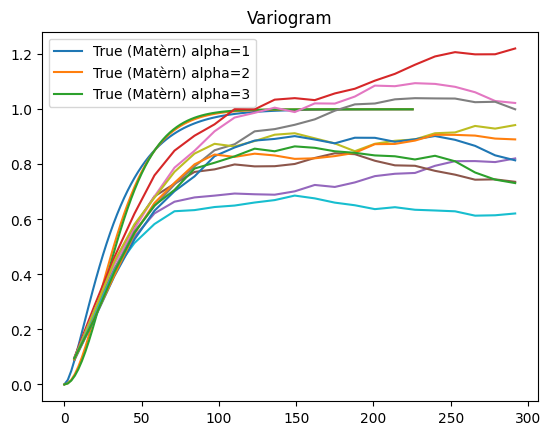

In [54]:
max_distance = np.sqrt((nx * dx) ** 2 + (ny * dy) ** 2) / 4
x = np.linspace(0, max_distance, 100)
# Compute the analytical variogram
mat_val_a1 = 1 - spde.matern_kernel(x, l=1 / kappa, v=nu1)
mat_val_a2 = 1 - spde.matern_kernel(x, l=1 / kappa, v=nu2)
mat_val_a3 = 1 - spde.matern_kernel(x, l=1 / kappa, v=nu3)

plt.plot(x, mat_val_a1, label="True (Matèrn) alpha=1")
plt.plot(x, mat_val_a2, label="True (Matèrn) alpha=2")
plt.plot(x, mat_val_a3, label="True (Matèrn) alpha=3")

nb_sim = 10  # number of simulations

X, Y = np.meshgrid(np.arange(nx) * dx, np.arange(ny) * dy)

for i in range(nb_sim):
    z0_1 = spde.simu_nc(cholQ_a1, rng)
    # z0_2 = spde.simu_nc(cholQ_a2, rng)
    # z0_3 = spde.simu_nc(cholQ_a3, rng)

    bin_center_1, gamma_1 = gs.vario_estimate(
        np.array((X.ravel(), Y.ravel())),
        field=z0_1.ravel(),
        sampling_size=int(0.1 * (nx * ny)),
    )
    #     # bin_center_2, gamma_2 = gs.vario_estimate(np.array((X.ravel(), Y.ravel())), field=z0_2.ravel())
    #     # bin_center_3, gamma_3 = gs.vario_estimate(np.array((X.ravel(), Y.ravel())), field=z0_3.ravel())

    #     # varexp_alpha1 = varexp_alpha1 + spde.get_exp_var(z0_1, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim
    #     # varexp_alpha2 = varexp_alpha2 + spde.get_exp_var(z0_2, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim
    #     # varexp_alpha3 = varexp_alpha3 + spde.get_exp_var(z0_3, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim

    plt.plot(bin_center_1, gamma_1)


plt.title("Variogram")
plt.legend()
plt.show()

## 3d case

In [62]:
spatial_dim: int = 3
nx: int = 100
ny: int = 100
nz = 30
dx = dy = dz = 1.0  # mesh size
kappa: float = 1 / 20  # inverse of length scale

In [63]:
alpha1 = 1
nu1 = 2 * alpha1 - spatial_dim / 2
Q_a1 = spde.get_precision_matrix_3d(nx, ny, nz, dx, dy, dz, kappa, alpha1)
alpha2 = 2
nu2 = 2 * alpha2 - spatial_dim / 2
Q_a2 = spde.get_precision_matrix_3d(nx, ny, nz, dx, dy, dz, kappa, alpha2)
alpha3 = 3
nu3 = 2 * alpha3 - spatial_dim / 2
Q_a3 = spde.get_precision_matrix_3d(nx, ny, nz, dx, dy, dz, kappa, alpha3)

In [57]:
nu1

0.5

In [58]:
nu2

2.5

In [59]:
nu3

4.5

In [64]:
logging.info(f"Q_a1 sparcity = {Q_a1.count_nonzero() / np.product(Q_a1.shape):.6f}")
logging.info(f"Q_a2 sparcity = {Q_a2.count_nonzero() / np.product(Q_a2.shape):.6f}")
logging.info(f"Q_a3 sparcity = {Q_a3.count_nonzero() / np.product(Q_a3.shape):.6f}")

INFO:root:Q_a1 sparcity = 0.000081
INFO:root:Q_a2 sparcity = 0.000081
INFO:root:Q_a3 sparcity = 0.000081


In [61]:
from scipy.sparse.linalg import splu

In [32]:
splu(Q_a1)

/home/acollet/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


KeyboardInterrupt: 

In [65]:
# white noise with size nx * ny -> scale is the standard deviation
w = rng.normal(loc=0, scale=np.sqrt(1 / np.prod([dx, dy, dz])), size=Q_a1.shape[0])

# Use a LU preconditioner to get faster computation
z, info = gmres(Q_a1, w, M=spde.get_preconditioner(Q_a1), atol=1e-15)

/home/acollet/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


(array([  51.,  176.,  561., 2265., 2405., 1970., 1742., 1543., 1253.,
        1124.,  965.,  927.,  830.,  812.,  718.,  668.,  652.,  569.,
         534.,  515.,  480.,  461.,  433.,  398.,  382.,  354.,  360.,
         337.,  307.,  279.,  301.,  246.,  265.,  223.,  215.,  201.,
         189.,  190.,  141.,  156.,  137.,  113.,  112.,   90.,   91.,
          73.,   68.,   51.,   44.,   23.]),
 array([-3.19987271, -2.23701768, -1.27416266, -0.31130764,  0.65154739,
         1.61440241,  2.57725744,  3.54011246,  4.50296748,  5.46582251,
         6.42867753,  7.39153256,  8.35438758,  9.31724261, 10.28009763,
        11.24295265, 12.20580768, 13.1686627 , 14.13151773, 15.09437275,
        16.05722777, 17.0200828 , 17.98293782, 18.94579285, 19.90864787,
        20.87150289, 21.83435792, 22.79721294, 23.76006797, 24.72292299,
        25.68577801, 26.64863304, 27.61148806, 28.57434309, 29.53719811,
        30.50005314, 31.46290816, 32.42576318, 33.38861821, 34.35147323,
        35.31432

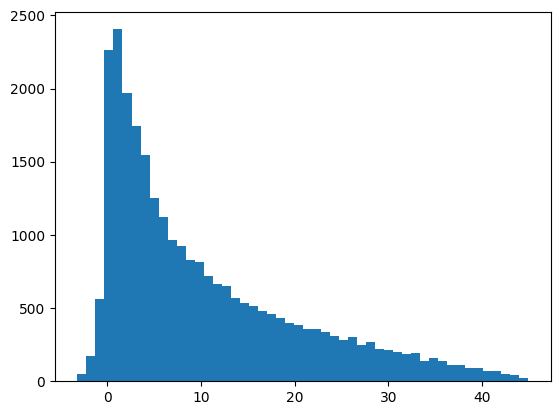

In [30]:
plt.hist(z, bins=50)

# Non conditional simulation from precision matrix

In [49]:
# cholQ_a1 = cholesky(Q_a1.tocsc())
# z_nc_a1 = spde.simu_nc(cholQ_a1, rng)

# cholQ_a2 = cholesky(Q_a2.tocsc())
# z_nc_a2 = spde.simu_nc(cholQ_a2, rng)

# cholQ_a3 = cholesky(Q_a3.tocsc())
# z_nc_a3 = spde.simu_nc(cholQ_a3, rng)

NameError: name 'multi_imshow' is not defined

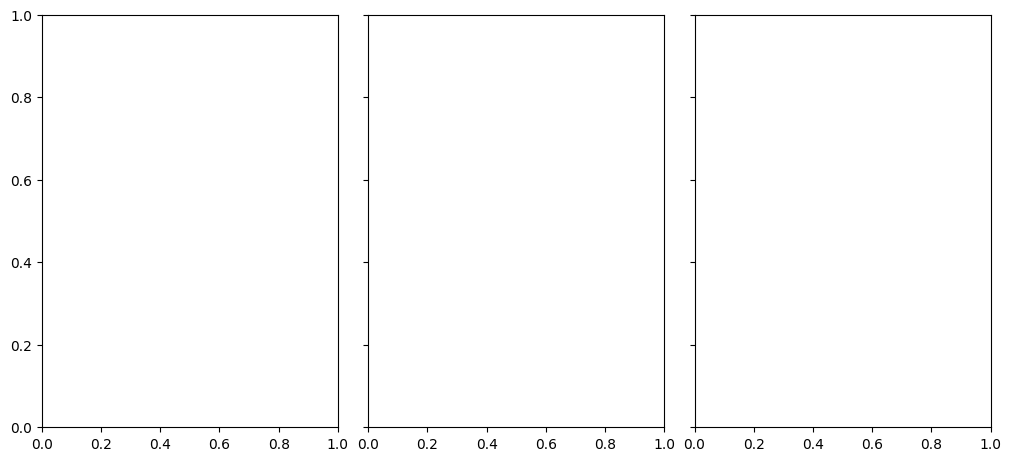

In [1]:
from nested_grid_plotter import NestedGridPlotter

plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 4.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "NC simu ($alpha=1$)": z_nc_a2.reshape(nx, ny, nz, order="F")[:, :, 4] * 2,
        "NC simu ($alpha=2$)": z_nc_a2.reshape(nx, ny, nz, order="F")[:, :, 4] * 4,
        "NC simu ($alpha=3$)": z_nc_a2.reshape(nx, ny, nz, order="F")[:, :, 4] * 8,
    },
    cbar_title="Z(s)",
    imshow_kwargs={
        "cmap": plt.get_cmap("viridis"),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
        "aspect": "equal",
    },
    xlabel="X (m)",
    ylabel="Y (m)",
)

fname = "nc_simu_effect_of_regularity_parameter"
for format in ["png", "pdf"]:
    plotter.fig.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [37]:
np.std(z_nc_a1)

0.38192205196789086

## Case of varying correlation range ($\kappa$)

- Function for linear_gradient

In [31]:
def linear_gradient(
    coords: NDArrayFloat, val_min: float, val_max: float
) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    coords : NDArrayFloat
        Points coordinates (2, npts).
    vlr_min : float
        Minimum gradient value.
    val_max : float
        Maximum gradient value.

    Returns
    -------
    NDArrayFloat
        The gradient.
    """

    return np.exp(np.log(val_min) + (np.log(val_max) - np.log(val_min)) * coords[:, 0])

In [32]:
def create_grid_coordinates(shape: NDArrayInt, mesh_dim: NDArrayFloat) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    shape : NDArrayInt
        _description_
    mesh_dim : NDArrayFloat
        _description_

    Returns
    -------
    NDArrayFloat
        _description_
    """
    xmin: NDArrayFloat = np.array((mesh_dim)) / 2.0
    xmax = (np.array(shape) - 0.5) * mesh_dim

    x1 = np.linspace(xmin[0], xmax[0], shape[0])
    x2 = np.linspace(xmin[1], xmax[1], shape[1])
    xx, yy = np.meshgrid(x1, x2, indexing="ij")
    return np.vstack((np.ravel(xx, order="F"), np.ravel(yy, order="F"))).transpose()

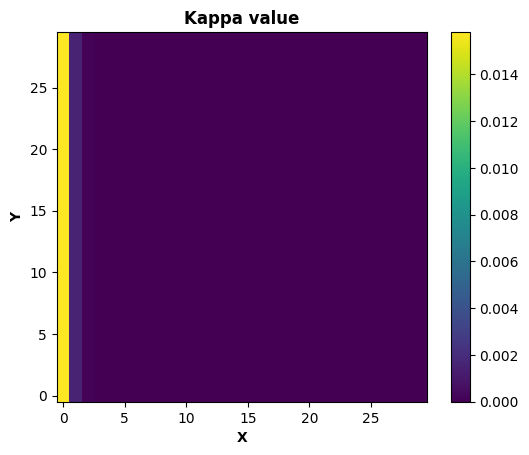

In [33]:
coords = create_grid_coordinates(np.array([nx, ny]), np.array([dx, dy]))
varying_kappa = 1 / linear_gradient(coords, val_min=1 / kappa, val_max=1 / kappa * 10.0)

plt.imshow(varying_kappa.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Kappa value", fontweight="bold")
plt.colorbar()

- Create the precision matrices

In [34]:
alpha4 = alpha1
nu4 = 2 * alpha1 - spatial_dim / 2
Q_a4 = spde.get_precision_matrix_2d(nx, ny, dx, dy, varying_kappa, alpha4)

In [35]:
Q_a4

<900x900 sparse matrix of type '<class 'numpy.float64'>'
	with 11104 stored elements in COOrdinate format>

In [36]:
cholQ_a4 = cholesky(Q_a4.tocsc())
z_nc_a4 = simu_nc2(cholQ_a4, rng)

plt.imshow(z_nc_a4.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

CholmodNotPositiveDefiniteError: ../Supernodal/t_cholmod_super_numeric.c:911: matrix not positive definite (code 1)

## Dealing with anisotropies

In [ ]:
gamma = 1.0
beta = 8.0
theta = np.pi / 4
v = np.array([np.cos(theta), np.sin(theta)]).T

# TODO: maybe use a cache function ???

H = gamma * np.eye(2) + beta * v[:, np.newaxis] * v[:, np.newaxis].T


def _example31(x: float, y: float) -> NDArrayFloat:
    """Return a matrix."""
    return H.T

In [ ]:
Q_test = get_precision_matrix_2d(200, 200, 0.1, 0.1, 1.0, 1, is_use_mass_lumping=False)

NameError: name 'get_precision_matrix_2d' is not defined

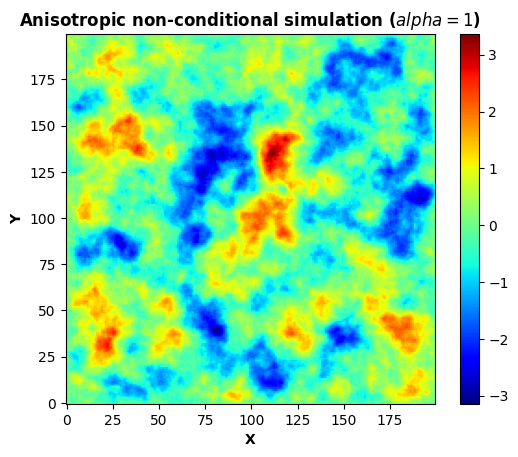

In [ ]:
cholQ_test = cholesky(Q_test.tocsc())
z_nc_test = simu_nc2(cholQ_test, rng)

plt.imshow(z_nc_test.reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [ ]:
Q_ex31 = get_precision_matrix_2d(
    200, 200, 0.1, 0.1, 1.0, 1, False, anisotropy_function=_example31
)

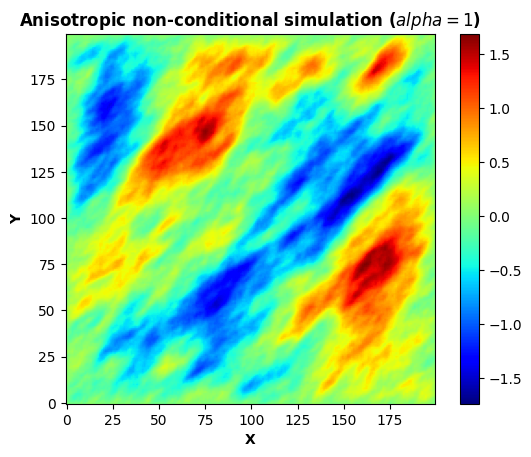

In [ ]:
cholQ_ex31 = cholesky(Q_ex31.tocsc())
z_nc_ex31 = simu_nc2(cholQ_ex31, rng)

plt.imshow(z_nc_ex31.reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

- Compute and plot correlation

In [ ]:
# idx = int(center.size/2)

# corr = np.zeros(center.size)
# _Q_test = Q_test.tocsc()

# for i in range(center.size):
#     if _Q_test[i, idx] != 0:
#         print(_Q_test[i, idx])
#     corr[i] = _Q_test[i, idx] / (_Q_test[i, i] * _Q_test[idx, idx])

## Anisotropies in the non-stationary case

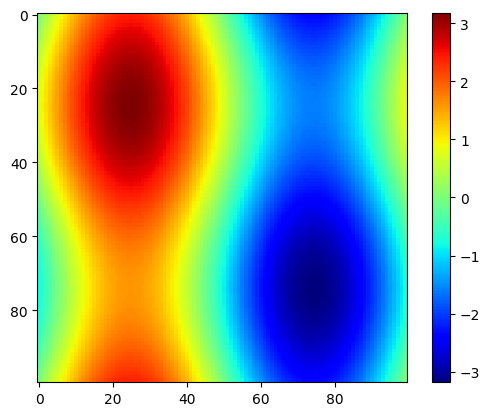

In [ ]:
def _example32(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return (
        10
        / np.pi
        * (
            3.0 / 4.0 * np.sin(2 * np.pi * x / 20.0)
            + 1.0 / 4.0 * np.sin(2 * np.pi * y / 20.0)
        )
    )


X, Y = np.meshgrid(np.linspace(0, 20, 100), np.linspace(0, 20, 100))

field = _example32(X, Y)

plt.imshow(field, cmap="jet")
plt.colorbar()

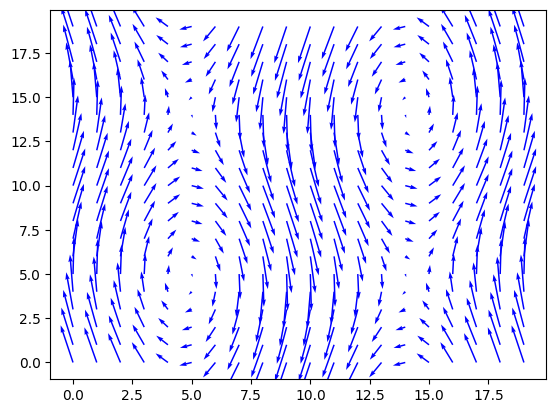

In [ ]:
def _example32_gradient(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return (
        10
        / np.pi
        * np.array(
            [
                -1.0 / 4.0 * np.cos(2 * np.pi * y / 20.0) * 2 * np.pi / 20.0,
                3.0 / 4.0 * np.cos(2 * np.pi * x / 20.0) * 2 * np.pi / 20.0,
            ]
        )
    )


X, Y = np.meshgrid(np.linspace(0, 20, 20), np.linspace(0, 20, 20))
gradient_field = _example32_gradient(X, Y)

plt.quiver(gradient_field[0], gradient_field[1], scale=10, color="blue")

In [ ]:
def _wrapper_ex32(x: float, y: float) -> NDArrayFloat:
    v = _example32_gradient(x, y)
    return (0.1 * np.eye(2) + 25 * v[:, np.newaxis] * v[:, np.newaxis].T).T

In [ ]:
X1, X2 = np.array([3, 4, 5]), np.array([3, 4, 5])

for i in range(X1.size):
    print(scipy.linalg.det(_wrapper_ex32(X1[i], X2[i])))

0.5498304731445718
0.15920547314457245
0.010000000000000002


In [ ]:
def get_marginal_variance_2d(
    x: NDArrayFloat,
    y: NDArrayFloat,
    kappa: NDArrayFloat,
    dx: float,
    dy: float,
    anisotropy_function: Callable,
) -> NDArrayFloat:
    var_ = np.zeros(x.size)

    for i in range(x.size):
        var_[i] = scipy.linalg.det(anisotropy_function(x[i], y[i]))

    return 1.0 / (4 * np.pi * var_ * kappa**2) * np.sqrt(np.prod([dx, dy]))


def get_marginal_variance_3d(
    x: NDArrayFloat,
    y: NDArrayFloat,
    kappa: NDArrayFloat,
    dx: float,
    dy: float,
    dz: float,
    anisotropy_function: Callable,
) -> NDArrayFloat:
    var_ = np.zeros(x.size)

    for i in range(x.size):
        var_[i] = scipy.linalg.det(anisotropy_function(x[i], y[i], z[i]))

    return 1.0 / (8 * np.pi * var_ * kappa**2) * np.sqrt(np.prod([dx, dy, dz]))

In [ ]:
nx = ny = 200
dx = dy = 0.1
X, Y = np.meshgrid(np.linspace(0.0, nx * dx, nx), np.linspace(0.0, ny * dy, ny))

# _example32_gradient(X.ravel(), Y.ravel())
# _wrapper_ex32(X.ravel(), Y.ravel()).reshape(nx, ny)
X = X.ravel()
Y = Y.ravel()


marginal_variance = get_marginal_variance_2d(Y, X, 1.0, dx, dy, _wrapper_ex32)

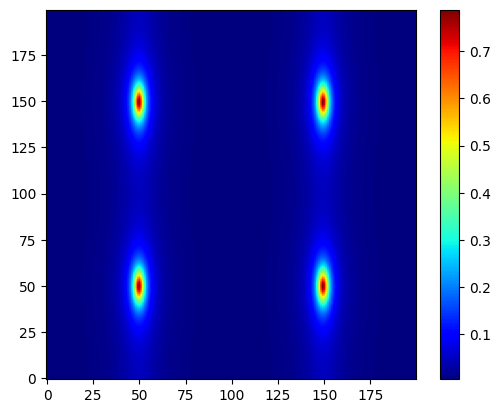

In [ ]:
plt.imshow(marginal_variance.reshape(nx, ny).T, origin="lower", cmap="jet")
plt.colorbar()

In [ ]:
Q_ex32 = get_precision_matrix_2d(
    200, 200, 0.1, 0.1, 1.0, 1, True, anisotropy_function=_wrapper_ex32
)

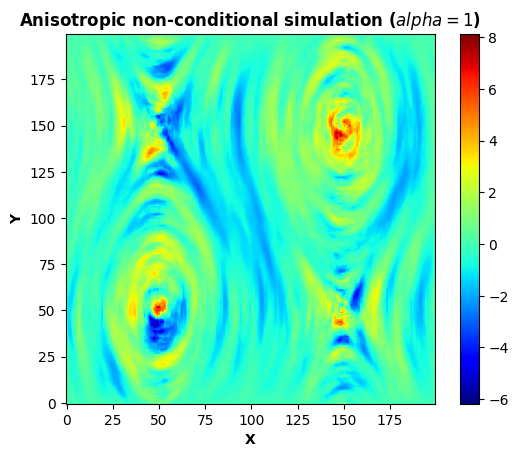

In [ ]:
cholQ_ex32 = cholesky(Q_ex32.tocsc())
z_nc_ex32 = simu_nc2(cholQ_ex32, rng)

plt.imshow((z_nc_ex32).reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

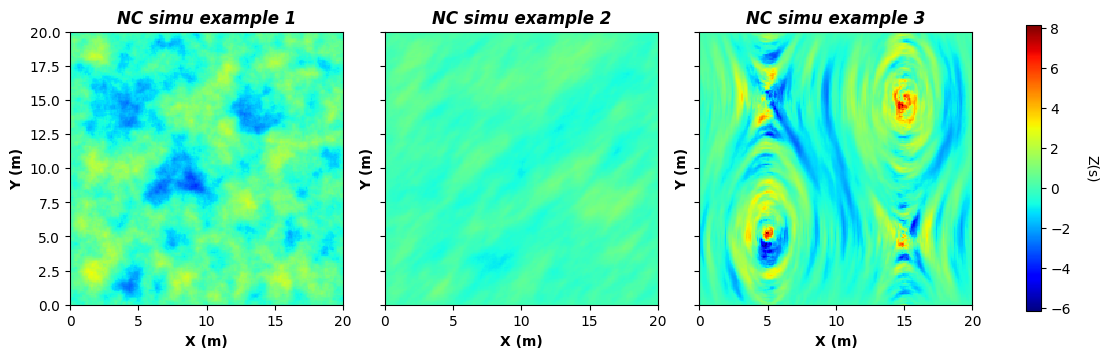

In [ ]:
from nested_grid_plotter import NestedGridPlotter

plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "NC simu example 1": z_nc_test.reshape(200, 200).T,
        "NC simu example 2": z_nc_ex31.reshape(200, 200).T,
        "NC simu example 3": z_nc_ex32.reshape(200, 200).T,
    },
    cbar_title="Z(s)",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, 20, 0.0, 20],
        "aspect": "equal"
        # "vmin": 50,
        # "vmax": 650,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
)

fname = "nc_simu_anisotropy"
for format in ["png", "pdf"]:
    plotter.fig.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Example roll front

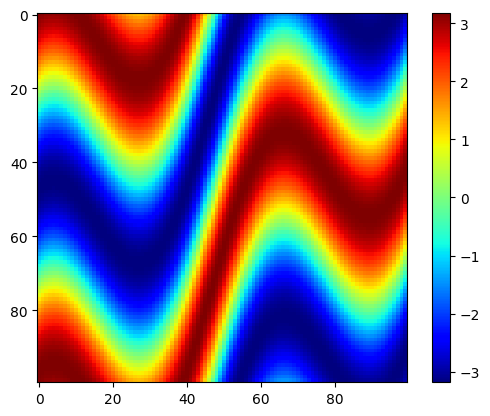

In [ ]:
def example_roll_front(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    # return np.cos(2 * np.pi * (x / 20 + y / 20))
    return (
        10 / np.pi * (np.sin((2 * np.pi * (y + 5 * np.cos(x / 2) + x) + np.pi) / 20.0))
    )


X, Y = np.meshgrid(np.linspace(0, 20, 100), np.linspace(0, 20, 100))

field = example_roll_front(X, Y)

plt.imshow(field, cmap="jet")
plt.colorbar()

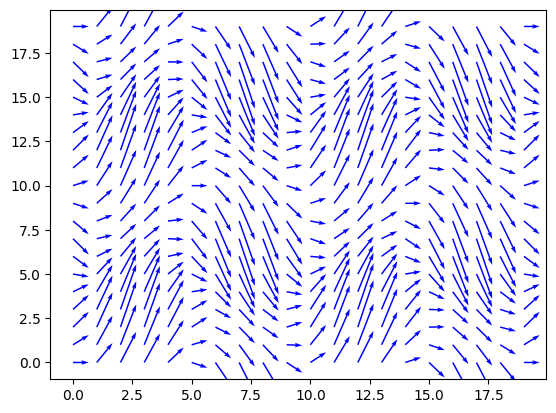

In [ ]:
def example_roll_front_gradient(x: float, y: float) -> NDArrayFloat:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return (
        10
        / np.pi
        * np.array(
            [
                (1 / (20**2))
                * (40 * np.pi - 100 * np.pi * np.sin(x / 2))
                * np.cos((2 * np.pi * (y + 5 * np.cos(x / 2) + x) + np.pi) / 20.0),
                -(1 / 20**2)
                * (
                    40
                    * np.pi
                    * np.sin((2 * np.pi * (y + 5 * np.cos(x / 2) + x) + np.pi) / 20.0)
                ),
            ]
        )
    )


def example_roll_front_gradient(x: float, y: float) -> NDArrayFloat:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    # cos(x+2*y), sin(x-2*y)
    return (
        10
        / np.pi
        * np.array(
            [
                x * 0.0 + 1.0,  # -np.cos(np.pi * x),
                2 * np.sin(np.pi * (x) / 5) + np.sin((np.pi * (y) / 5)),
            ]
        )
    )


X, Y = np.meshgrid(np.linspace(0, 20, 20), np.linspace(0, 20, 20))
gradient_field = example_roll_front_gradient(X, Y)

plt.quiver(gradient_field[0], gradient_field[1], scale=100, color="blue")

In [ ]:
def wrapper_ex_rf(x: float, y: float) -> NDArrayFloat:
    v = example_roll_front_gradient(x, y)
    return (0.1 * np.eye(2) + 25 * v[:, np.newaxis] * v[:, np.newaxis].T).T

In [ ]:
Q_ex_rf = get_precision_matrix_2d(
    200, 200, 0.1, 0.1, 1.0, 1, True, anisotropy_function=wrapper_ex_rf
)

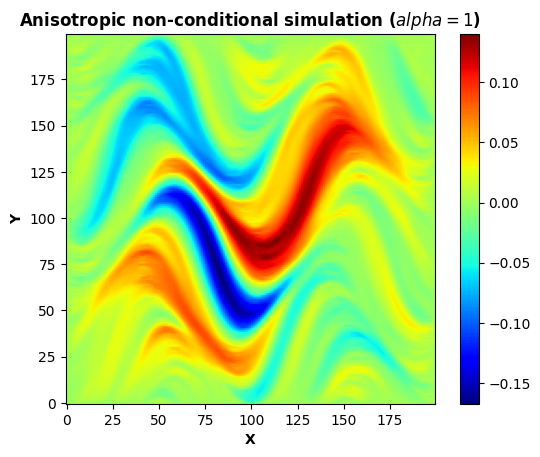

In [ ]:
cholQ_ex_rf = cholesky(Q_ex_rf.tocsc())
z_nc_ex_rf = simu_nc2(cholQ_ex_rf, rng)

plt.imshow((z_nc_ex_rf).reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [ ]:
marginal_variance_rf = get_marginal_variance_2d(X, Y, 1.0, dx, dy, wrapper_ex_rf)

ValueError: operands could not be broadcast together with shapes (2,1,100) (100,1,2) 

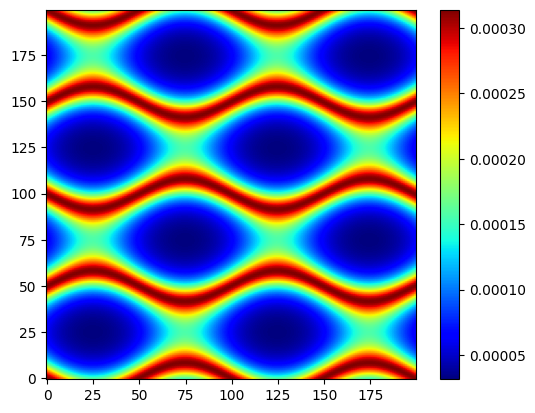

In [ ]:
plt.imshow(marginal_variance_rf.reshape(nx, ny).T, origin="lower", cmap="jet")
plt.colorbar()

# 3D case

In [ ]:
gamma = 1.0
beta = 8.0
theta = np.pi / 4
eta = np.pi / 4
v = np.array([np.cos(theta), np.sin(theta), 0.0]).T

# I need to check how it works for three dimensions ?

# TODO: maybe use a cache function ???

H = (
    gamma * np.eye(3)
    + beta * v[:, np.newaxis, np.newaxis] * v[:, np.newaxis, np.newaxis].T
)


def _example31(x: float, y: float) -> NDArrayFloat:
    """Return a matrix."""
    return H.T

In [ ]:
Q_test = get_precision_matrix_3d(20, 20, 20, 0.1, 0.1, 0.1, 1.0, 1, True)

IndexError: column index (8001) out of bounds

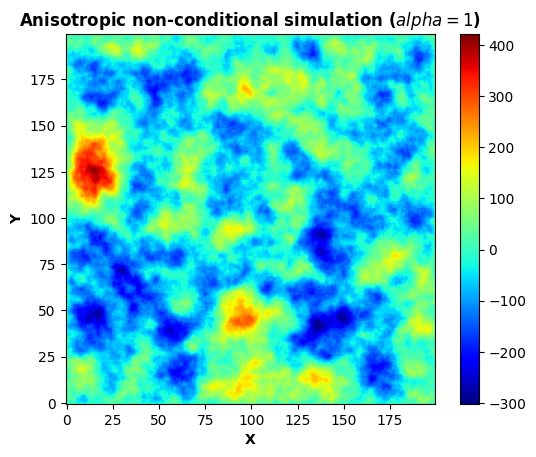

In [ ]:
cholQ_test = cholesky(Q_test.tocsc())
z_nc_test = simu_nc2(cholQ_test, rng)

plt.imshow(z_nc_test.reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

## Kriging (case of $\alpha = 2$)

The kriging $\bm{Z}^{T}_{K}$ can be obtained from

$\bm{Z}^{K}_{T} = - (\bm{Q}_{TT})^{-1} \bm{Q}_{TD} \bm{Z}_{D}$ with $\bm{Q} = \begin{pmatrix}
  \bm{Q}_{DD} & \bm{Q}_{DT}\\ 
  \bm{Q}_{TD} & \bm{Q}_{TT}
\end{pmatrix}$, the precision matrix of $\bm {Z}$.

Then the linear system needs to be solved:

$\bm{Q}_{TT} \bm{Z}^{K}_{T} = - \bm{Q}_{TD} \bm{Z}_{D}$

It is done using the Cholesky decomposition of $\bm{Q}_{TT}$

1) Compute $L$ with the decomposition $\bm{Q}_{TT} = \bm{LL}^{T}$
2) Solve the linear system $\bm{LX} = - \bm{Q}_{TD} \bm{Z}_{D}$
3) Solve the linear system $\bm{L}\bm{Z}^{K}_{T} = \bm{X}$

- We sample the previous non conditional simulation (200 data points) and plot it

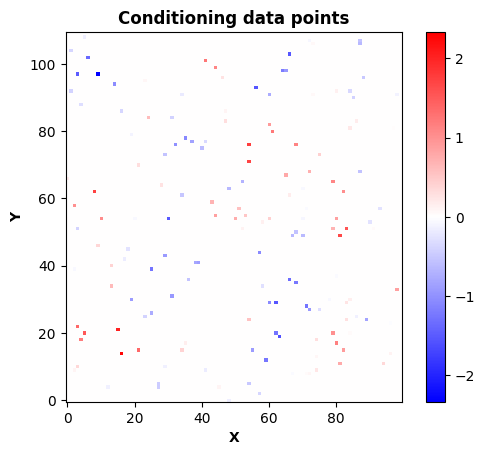

In [ ]:
# Indices of data points (D)  -> 150 points
indexes_dat = np.sort(rng.choice(nx * ny, size=150, replace=False))

# Also select points regularly along a certain line (to be sure we have enough points to vizualize later on)
id_check_row = 50  # index of a line
id_check_sel_all = (
    np.arange(0, nx) + (id_check_row - 1) * ny
)  # indices along this lines
id_check_sel_dat = (
    np.arange(0, nx, step=10) + (id_check_row - 1) * ny
)  # indices along this row (every 10 points)

# Merge the indexes_dat + delete duplicates
indexes_dat = np.unique(np.hstack([indexes_dat, id_check_sel_dat]))

# Indices of unknonws (targets - T) -> 9800 points
indexes_tar = np.delete(np.arange(nx * ny), indexes_dat)

# Vector of data (Z_D)
dat = z_nc_a2[indexes_dat]

# Display the data in the grid
dat_pts = np.zeros((nx * ny))  # 1D empty array
dat_pts[indexes_dat] = dat
# Plot the data points (make it 2D with reshape)
plt.imshow(
    dat_pts.reshape(ny, nx),
    cmap=plt.get_cmap("bwr"),
    norm=colors.CenteredNorm(),
    origin="lower",
)
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Conditioning data points", fontweight="bold")
plt.plot()
plt.colorbar()

- Define a matrix for advanced and efficient slicing of sparse matrices

In [ ]:
def slice_sparse(
    A: csc_matrix, row_indexes: NDArrayInt, col_indexes: NDArrayInt
) -> csc_matrix:
    B = A.tocsc()  # or `.tocsr()`
    B = B[np.array(row_indexes)[:, np.newaxis], np.array(col_indexes)]
    return B

- QTD sub-matrix from the precision matrix (9800 * 200)

In [ ]:
QTD_a2: csc_matrix = slice_sparse(Q_a2, indexes_tar, indexes_dat)
QTD_a2.shape

(10840, 160)

- QTT sub-matrix from the precision matrix (9800 * 9800)

In [ ]:
QTT_a2 = slice_sparse(Q_a2, indexes_tar, indexes_tar)
QTT_a2

<10840x10840 sparse matrix of type '<class 'numpy.float64'>'
	with 425852 stored elements in Compressed Sparse Column format>

-  Cholesky factorization of QTT

In [ ]:
QTT_factor_a2 = cholesky(QTT_a2)

- Write a function for the process

In [ ]:
def decompose_precison_matrix(
    Q: csc_matrix, indexes_dat: NDArrayInt, indexes_tar: NDArrayInt
) -> Tuple[csc_matrix, Factor]:
    QTD: csc_matrix = slice_sparse(Q, indexes_tar, indexes_dat)
    QTT_factor = cholesky(slice_sparse(Q, indexes_tar, indexes_tar))

    return QTD, QTT_factor

- Define a function that returns a kriggin

In [ ]:
def krig_chol(
    QTT_factor: Factor, QTD: csc_matrix, dat: NDArrayFloat, indexes_dat: NDArrayInt
) -> NDArrayFloat:
    """
    Returns the kriging fo the component of a gaussian vector.

    Parameters
    ----------
    QTT_factor: Factor
        Cholesky factorization of QTT sub matrix.
    QTD : csc_matrix
        QTD sub matrix of Q.
    dat : NDArrayFloat
        Known data values.
    indexes_dat : NDArrayInt
        Known data indices in the grid.

    Returns
    -------
    NDArrayFloat
    Vector of kriged values.
    """
    right_term = -QTD.dot(dat)

    # Direct way
    zT_k = QTT_factor(right_term)
    # this is a wrapping for: zT_k=QTT_factor.solve_A(right_term)

    # Note; this is like doing:
    # zT_k = QTT_factor.apply_Pt(QTT_factor.solve_LDLt(QTT_factor.apply_P(right_term)))

    # Build the output vector
    nb_nodes = np.sum(QTD.shape)
    z_k = np.zeros(nb_nodes)
    # Affect the known values
    z_k[indexes_dat] = dat
    # Affect the kriged values
    indexes_tar = np.delete(np.arange(nb_nodes), indexes_dat)
    z_k[indexes_tar] = zT_k

    return z_k

In [ ]:
z_k_a2 = krig_chol(QTT_factor_a2, QTD_a2, dat, indexes_dat)

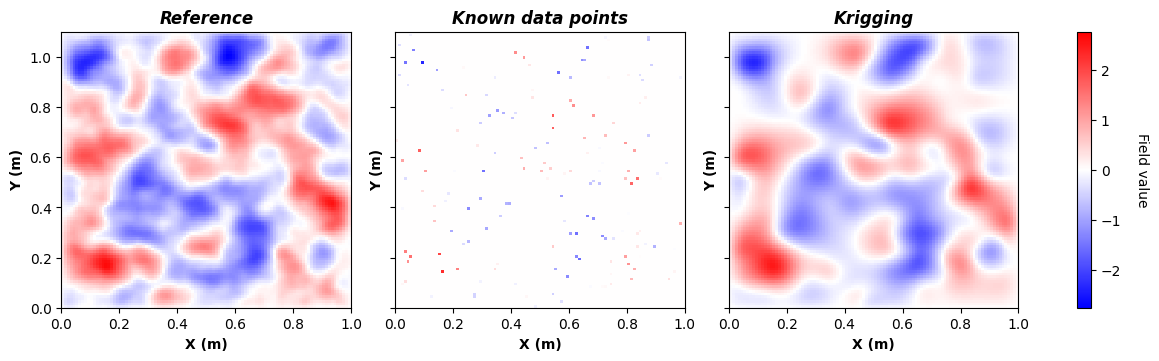

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11.5, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True,
)

## Conditional simulation

A conditional simulation of $\bm{Z}$ can be obtained in three times:

- Generate a non conditional simulation $\bm{Z}_{NC}$ of $\bm{Z}$
- Compute the kirging $\bm{Z}^{K}_{NC}$ of the values of the non conditional simulation $\bm{Z}_{NC}$ at the data points.
- Generate a conditional simulation with the formula

$\bm{Z}_{C} =  \bm{Z}^{K} + (Z_{NC} - \bm{Z}^{K}_{NC})$

- Other non conditional simulation

In [ ]:
z_nc_new = simu_nc2(cholQ_a2, nx * ny, rng)
dat_nc_new = z_nc_new[indexes_dat]
z_nck_new = krig_chol(QTT_factor_a2, QTD_a2, dat_nc_new, indexes_dat)

In [ ]:
z_c_a2 = z_k_a2 - (z_nc_new - z_nck_new)

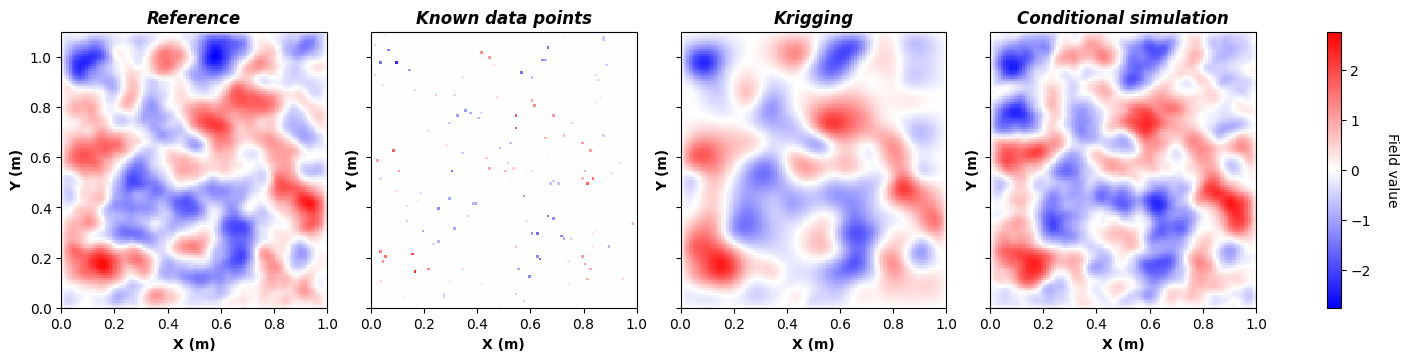

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "axes1-4"]], sharey=True, sharex=True
        )
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
        "Conditional simulation": z_c_a2.reshape(ny, nx).T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True,
)

- Check that the data points are honored (the difference should be zero)

In [ ]:
z_c_a2[indexes_dat] - dat

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

- General method to achieve that (note that the Cholesky decomposition is applied before, so that the method could be called a great number of times)

In [ ]:
def simu_cond(
    cholQ: Factor,
    QTT_factor: Factor,
    QTD: csc_matrix,
    dat: NDArrayFloat,
    indexes_dat: NDArrayInt,
    rng,
) -> NDArrayFloat:
    z_k = krig_chol(QTT_factor, QTD, dat, indexes_dat)
    z_nc = simu_nc2(cholQ, z_k.size, rng)
    dat_nc = z_nc[indexes_dat]
    z_nck = krig_chol(QTT_factor, QTD, dat_nc, indexes_dat)
    return z_k - (z_nc - z_nck)

- Test the function and plot the results

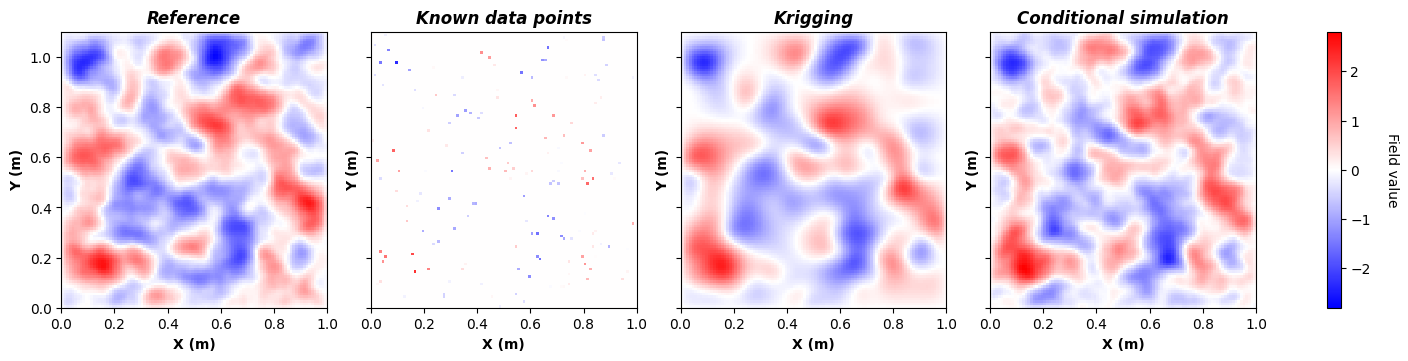

In [ ]:
z_c_a2_test = simu_cond(cholQ_a2, QTT_factor_a2, QTD_a2, dat, indexes_dat, rng)

plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "axes1-4"]], sharey=True, sharex=True
        )
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
        "Conditional simulation": z_c_a2_test.reshape(ny, nx).T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True,
)

- Should also be zero everywhere

In [ ]:
z_c_a2_test[indexes_dat] - dat

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

## Considering data points uncertainty

- Create a function to generate an artificial variance on the domain

In [ ]:
def reversed_beta_cumulative(x: NDArrayFloat, beta: float = 3) -> NDArrayFloat:
    """
    Transform the input with 1/ (1 + (1 / (1 - x)) ^ beta)

    Parameters
    ----------
    x : np.ndarray
        Input array. Idealy, values should be between 0. and 1.0.
    beta: float, optional
        Shape factor. Must be strictly positive. The default is 3.

    Returns
    -------
    np.ndarray.
        Array of same dimension as input array.

    """
    if beta <= 0:
        raise ValueError(f"Beta ({beta}) should be strictly positive !")

    x2 = x.copy()
    x2[x <= 0] = np.nan
    x2[x >= 1] = np.nan
    fact = np.where(np.isnan(x2), 0.0, 1.0 / (1.0 + np.power((x2 / (1 - x2)), -beta)))
    fact[x >= 1] = 1
    return 1 - fact


def create_variance_circle(
    coords: NDArrayFloat,
    var_min: float,
    var_max: float,
    beta: float,
    scaling_factor: float,
) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    coords : NDArrayFloat
        Points coordinates (2, npts).
    var_min : float
        _description_
    var_max : float
        _description_

    Returns
    -------
    NDArrayFloat
        _description_
    """
    center_x = (np.max(coords[:, 0]) - np.min(coords[:, 0])) / 2
    center_y = (np.max(coords[:, 1]) - np.min(coords[:, 1])) / 2
    r = (
        np.sqrt((coords[:, 0] - center_x) ** 2 + (coords[:, 1] - center_y) ** 2)
        / scaling_factor
    )
    return var_min + var_max * reversed_beta_cumulative(r, beta)

- Plot an example of variance map (linear variation)

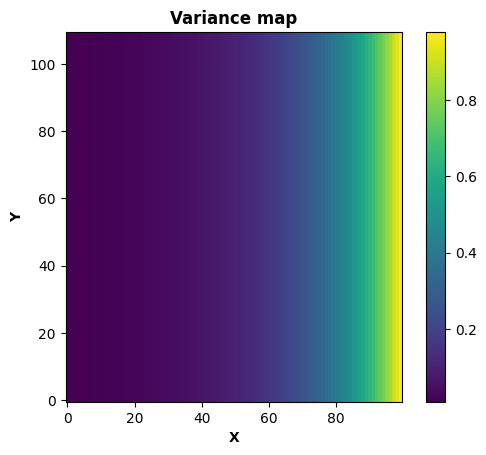

In [ ]:
coords = create_grid_coordinates(np.array([nx, ny]), np.array([dx, dy]))
grid_var = linear_gradient(coords, val_min=0.1**2, var_mal=1.0**2)

plt.imshow(grid_var.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Variance map", fontweight="bold")
plt.colorbar()

- Plot an example of variance map (circle version)

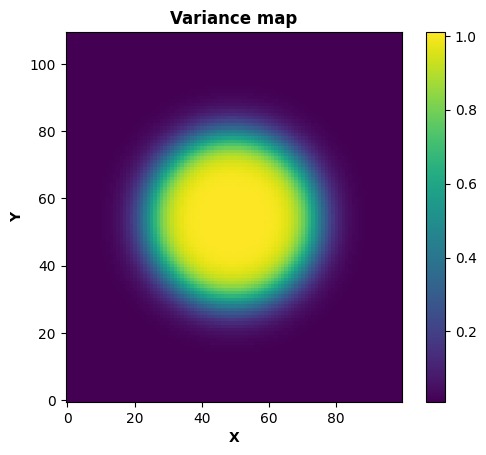

In [ ]:
coords = create_grid_coordinates(np.array([nx, ny]), np.array([dx, dy]))
grid_var = create_variance_circle(
    coords, var_min=0.1**2, var_max=1.0**2, beta=4, scaling_factor=0.5
)

plt.imshow(grid_var.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Variance map", fontweight="bold")
plt.colorbar()

In [ ]:
def condition_precision_matrix(
    Q: csc_matrix, indices_dat: NDArrayInt, var_dat: NDArrayFloat
) -> csc_matrix:
    """
    Condition the precision matrix with the variance of known data points.

    Parameters
    ----------
    Q : csc_matrix
        _description_
    indices_dat : NDArrayInt
        _description_
    var_dat : NDArrayFloat
        _description_

    Returns
    -------
    csc_matrix
        The conditionned precision matrix.
    """
    # Build the diagonal matrix containing the inverse of the error variance at known
    # data points

    diag_var = lil_matrix(Q.shape)
    diag_var[indexes_dat, indexes_dat] = 1 / var_dat
    return (diag_var + Q).tocsc()

### Krigging with uncertainty

In [ ]:
Q_a2_cond = condition_precision_matrix(Q_a2, indexes_dat, grid_var[indexes_dat])

In [ ]:
QTD_a2_cond, QTT_a2_cond_factor = decompose_precison_matrix(
    Q_a2_cond, indexes_dat, indexes_tar
)

In [ ]:
def krig_prec2(
    Q: csc_matrix,
    dat: NDArrayFloat,
    indexes_dat: NDArrayInt,
    cholQ: Optional[Factor] = None,
    dat_var: Optional[NDArrayFloat] = None,
) -> NDArrayFloat:
    if cholQ is None:
        _cholQ = cholesky(Q.tocsc())
    else:
        _cholQ = cholQ
    input = np.zeros(Q.shape[0])
    input[indexes_dat] = dat
    if dat_var is not None:
        input[indexes_dat] /= dat_var
    return _cholQ(input)

In [ ]:
z_k_a2_cond = krig_prec2(Q_a2_cond, dat, indexes_dat, dat_var=grid_var[indexes_dat])

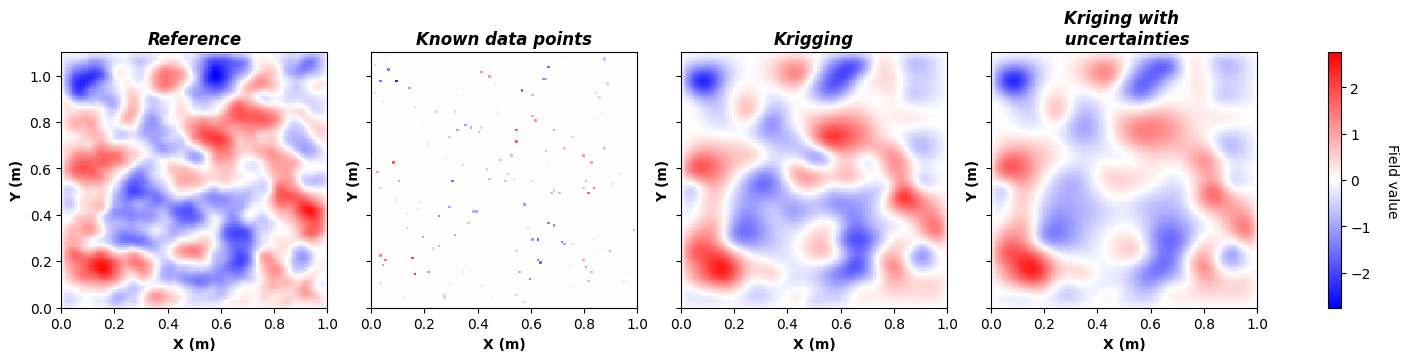

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "axes1-4"]], sharey=True, sharex=True
        )
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
        "Kriging with \n uncertainties": z_k_a2_cond.reshape(ny, nx).T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True,
)

In [ ]:
z_k_a2 - z_k_a2_cond

array([-0.0103576 , -0.01940323, -0.02612661, ..., -0.00062277,
       -0.00033691, -0.00014571])

- We can see that the variance is espacially high

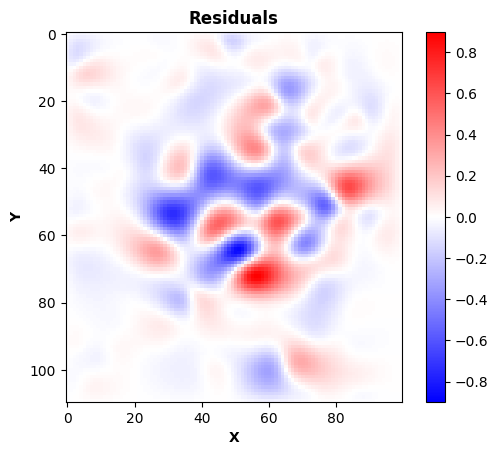

In [ ]:
plt.imshow(
    (z_k_a2 - z_k_a2_cond).reshape(ny, nx),
    cmap=plt.get_cmap("bwr"),
    norm=colors.CenteredNorm(),
)
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Residuals", fontweight="bold")
plt.colorbar()

## Conditional simulation with uncertainties

In [ ]:
def simu_cond_std(
    cholQ: Factor,
    Q_cond: csc_matrix,
    cholQ_cond: Factor,
    dat: NDArrayFloat,
    indexes_dat: NDArrayInt,
    rng,
) -> NDArrayFloat:
    z_k = krig_prec2(
        Q_cond, dat, indexes_dat, cholQ=cholQ_cond, dat_var=grid_var[indexes_dat]
    )
    # z_k = krig_prec2(Q_cond, dat * 1 / grid_var[indexes_dat], indexes_dat)
    z_nc = simu_nc2(cholQ, z_k.size, rng)
    dat_nc = z_nc[indexes_dat]
    # z_nck = krig_chol(QTT_factor, QTD, dat_nc, indexes_dat)
    z_nck = krig_prec2(
        Q_cond, dat_nc, indexes_dat, cholQ=cholQ_cond, dat_var=grid_var[indexes_dat]
    )
    return z_k - (z_nc - z_nck)

- Plot the values along a specific row + perform simulations

- performa conditional simulations taking into account the uncertainties on data points

In [ ]:
n_simu = 100
simus = np.zeros((n_simu, nx * ny))

cholQ_a2 = cholesky(Q_a2.tocsc())
cholQ_a2_cond = cholesky(Q_a2_cond.tocsc())

for i in range(n_simu):
    simus[i, :] = simu_cond_std(
        cholQ_a2, Q_a2_cond, cholQ_a2_cond, dat, indexes_dat, rng
    )

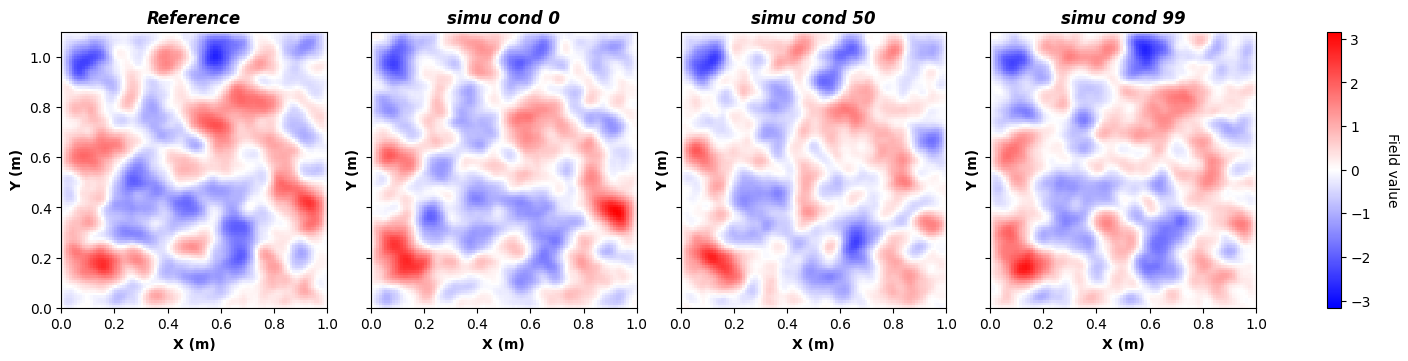

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1", "ax1-2", "ax1-3", "axes1-4"]], sharey=True, sharex=True
        )
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "simu cond 0": simus[0, :].reshape(ny, nx).T,
        "simu cond 50": simus[50, :].reshape(ny, nx).T,
        "simu cond 99": simus[99, :].reshape(ny, nx).T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True,
)

- Plot one row

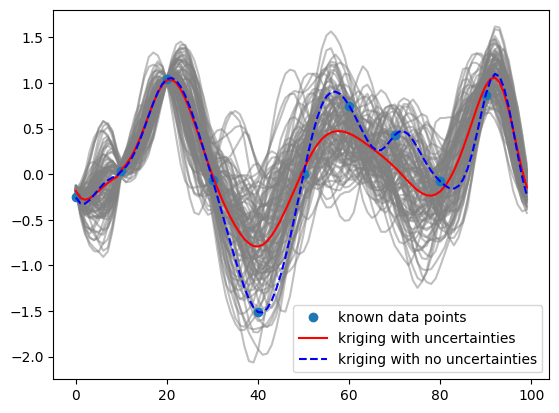

In [ ]:
plt.plot(simus[:, id_check_sel_all].T, color="grey", alpha=0.5)
plt.plot(
    np.arange(0, nx, step=10),
    z_k_a2[id_check_sel_dat],
    linestyle="none",
    marker="o",
    label="known data points",
)
plt.plot(z_k_a2_cond[id_check_sel_all], color="r", label="kriging with uncertainties")
plt.plot(
    z_k_a2[id_check_sel_all],
    color="b",
    label="kriging with no uncertainties",
    linestyle="--",
)
plt.legend()

- This time, the data points are not perfectly respected

In [ ]:
z_k_a2_cond[indexes_dat] - dat

array([ 8.00859241e-02,  1.44879850e-02,  1.48026951e-02,  8.55081038e-03,
       -2.92092775e-02, -2.81797607e-04, -1.01146555e-02, -2.07951297e-02,
        4.00407715e-03,  1.63806050e-02,  3.92944557e-02,  1.45435496e-02,
       -2.38652733e-02, -3.48782902e-02,  9.05860300e-03,  2.67173487e-03,
       -9.01170007e-03,  1.10826619e-02,  2.67363463e-02, -2.63381623e-02,
        1.39486598e-03,  5.19992893e-03, -4.19249247e-02,  8.02457435e-03,
       -2.46110057e-03,  3.52074073e-02, -3.19999509e-02,  4.37346194e-03,
       -6.90293485e-03,  8.73534659e-02,  2.13984358e-02, -9.33391965e-02,
       -9.26369253e-03,  3.03016482e-02, -1.25506245e-02, -4.42927221e-02,
       -1.91444310e-02, -2.38061330e-01,  6.38963199e-03,  6.19854015e-02,
       -8.42787983e-03, -5.88971124e-02,  1.46853475e-02, -3.21134483e-03,
        1.39758497e-03,  7.08641279e-02,  1.36831272e-01,  2.54783465e-01,
       -1.38587576e-02,  4.68025535e-02, -1.35108160e-02,  2.43516175e-02,
        2.52324639e-02, -

### Conditionnal simulation with uncertainty

## Regularization

From gaussian likelihood.

In [ ]:
def get_reg_loglikelihood(
    Qd: csc_matrix, param: NDArrayFloat, prior: NDArrayFloat
) -> float:
    residuals = param - prior
    return 1 / 2 * np.dot(residuals.T, Qd.dot(residuals))


def get_reg_loglikelihood_gradient(
    Qd: csc_matrix, param: NDArrayFloat, prior: NDArrayFloat
) -> NDArrayFloat:
    residuals = param - prior
    return Qd.dot(residuals)

### Test with the correct covariance function ($\alpha = 2$)

- The prior is null because we work directly with the residuals

In [ ]:
prior = np.zeros((nx * ny))

- Get the regularization with no data points to fit (only the variogram is encoded)

In [ ]:
get_reg_loglikelihood(Q_a2, z_k_a2_cond, prior)

41.07065194161061

- Get the regularization with the data points as a constraints

In [ ]:
get_reg_loglikelihood(Q_a2_cond, z_k_a2_cond, prior)

2862.5651906688254

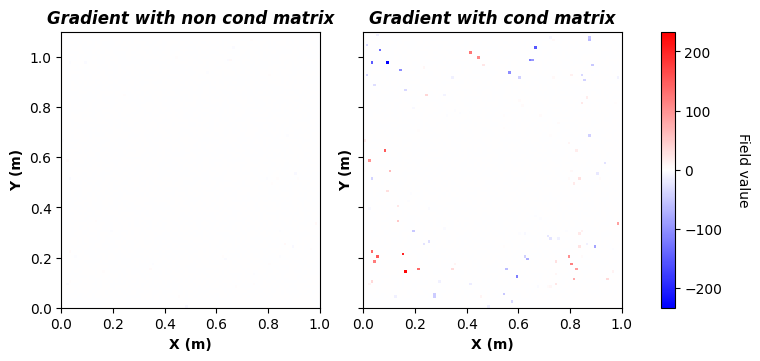

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (7.5, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Gradient with non cond matrix": get_reg_loglikelihood_gradient(
            Q_a2, z_k_a2_cond, prior
        )
        .reshape(ny, nx)
        .T,
        "Gradient with cond matrix": get_reg_loglikelihood_gradient(
            Q_a2_cond, z_k_a2_cond, prior
        )
        .reshape(ny, nx)
        .T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True,
)

### Test with the wrong covariance function ($\alpha = 1$)

- Generate a conditonal simulation but with $\alpha = 1$

In [ ]:
cholQ_a1 = cholesky(Q_a1.tocsc())
Q_a1_cond = condition_precision_matrix(Q_a1, indexes_dat, grid_var[indexes_dat])
cholQ_a1_cond = cholesky(Q_a1_cond.tocsc())

simu_cond_a1 = simu_cond_std(cholQ_a1, Q_a2_cond, cholQ_a2_cond, dat, indexes_dat, rng)

z_k_a1_cond = krig_prec2(Q_a1_cond, dat, indexes_dat, dat_var=grid_var[indexes_dat])

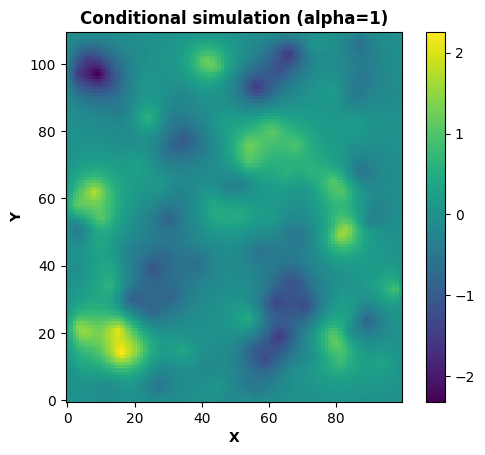

In [ ]:
plt.imshow(z_k_a1_cond.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Conditional simulation (alpha=1)", fontweight="bold")
plt.colorbar()

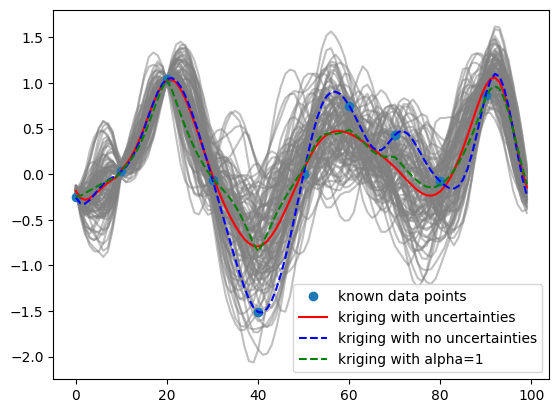

In [ ]:
plt.plot(simus[:, id_check_sel_all].T, color="grey", alpha=0.5)
plt.plot(
    np.arange(0, nx, step=10),
    z_k_a2[id_check_sel_dat],
    linestyle="none",
    marker="o",
    label="known data points",
)
plt.plot(z_k_a2_cond[id_check_sel_all], color="r", label="kriging with uncertainties")
plt.plot(
    z_k_a2[id_check_sel_all],
    color="b",
    label="kriging with no uncertainties",
    linestyle="--",
)
plt.plot(
    z_k_a1_cond[id_check_sel_all],
    color="g",
    label="kriging with alpha=1",
    linestyle="--",
)
plt.legend()

- Get the regularization with no data points to fit (only the variogram is encoded)

In [ ]:
get_reg_loglikelihood(Q_a2, z_k_a1_cond, prior)

1199.171877140002

- Get the regularization with the data points as a constraints

In [ ]:
get_reg_loglikelihood(Q_a2_cond, z_k_a1_cond, prior)

4049.813504896011

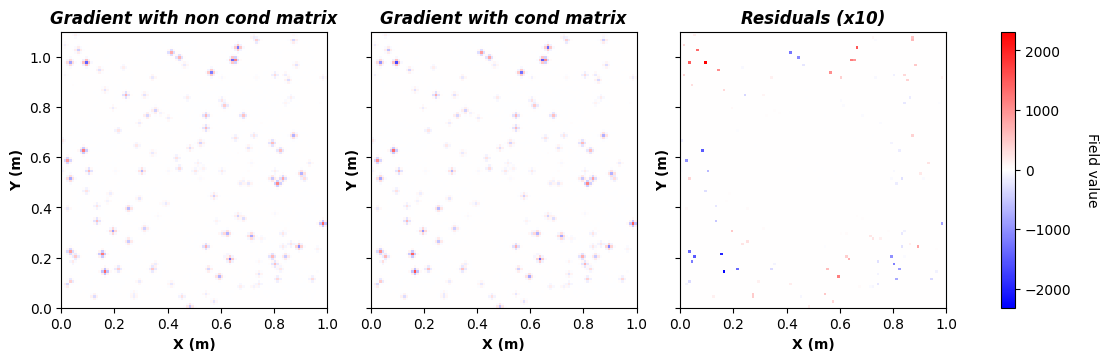

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Gradient with non cond matrix": get_reg_loglikelihood_gradient(
            Q_a2, z_k_a1_cond, prior
        )
        .reshape(ny, nx)
        .T,
        "Gradient with cond matrix": get_reg_loglikelihood_gradient(
            Q_a2_cond, z_k_a1_cond, prior
        )
        .reshape(ny, nx)
        .T,
        "Residuals (x10)": (
            get_reg_loglikelihood_gradient(Q_a2, z_k_a1_cond, prior)
            - get_reg_loglikelihood_gradient(Q_a2_cond, z_k_a1_cond, prior)
        )
        .reshape(ny, nx)
        .T
        * 10,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True,
)

In [ ]:
Q_a3

<11000x11000 sparse matrix of type '<class 'numpy.float64'>'
	with 897060 stored elements in Compressed Sparse Row format>

## Matern parameters estimation

- Let say we have 10 points with measures and the discretization 1000, then we can built a matrix A with size (1000, 10)

And the mesure points $y$ are defined by 

$$y_{1:10} = \mu + A^{T} x_{1:1000} + \sigma_{0} \epsilon$$

Donc ->

$$y_{1:10} = \mathcal{N}(\mu, \Sigma_{y} = A^{T}Q^{-1}A+\sigma_{0}^{2} I_{10})$$

Dans notre cas on estime $\mu$, $\sigma_{0}$ et $\kappa$, etc.


La vraisemblance:

$$\mathcal{L}(\Phi) = -\dfrac{n}{2}log(2\pi) - 1

 

In [ ]:
factor = cholesky(A)
ld = factor.logdet()